In [1]:
!pip install split-folders

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
base_ds = '/kaggle/input/cervical/MIaMIA-Open-Data-Cervical-AIS-Histopathology-Image-main'
base_ds = pathlib.Path(base_ds)

In [5]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(0.8,0.1,0.1), group_prefix=None)

Copying files: 2066 files [03:56,  8.72 files/s]


In [17]:
Abnormal= [fn for fn in os.listdir(f'{base_ds}/Abnormal') if (fn.endswith('.png')) ]
Normal= [fn for fn in os.listdir(f'{base_ds}/Normal') if (fn.endswith('.png'))]

cervical= [Abnormal, Normal]
cervical_classes = []
for i in os.listdir('imgs/train'):
    cervical_classes+=[i]
cervical_classes.sort()

In [21]:
print(cervical_classes)

['Abnormal', 'Normal']


Total images: 2064
Total number of classes: 2
Total Abnormal images: 1062
Total Normal images: 1002


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


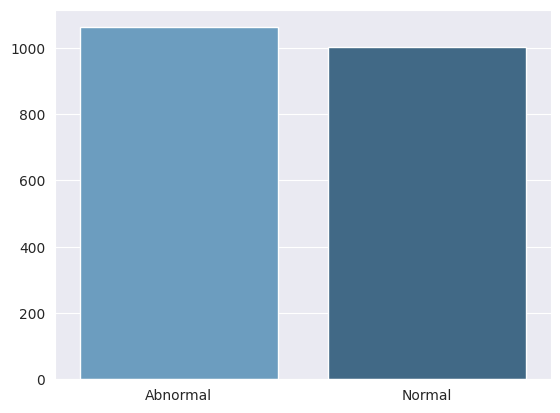

In [19]:
image_count1= len(list(base_ds.glob('*/*.png')))
image_count=image_count1
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(cervical_classes)}')
count = 0
cervical_count = []
for x in cervical_classes:
  print(f'Total {x} images: {len(cervical[count])}')
  cervical_count.append(len(cervical[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=cervical_classes, y=cervical_count, palette="Blues_d")
plt.show()

Image dimensions: (2160, 3840, 3)


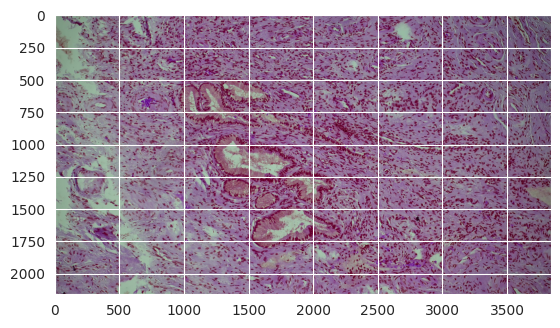

In [24]:
sample_img = cv2.imread('/kaggle/input/cervical/MIaMIA-Open-Data-Cervical-AIS-Histopathology-Image-main/Normal/Normal-0011.png')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [22]:
def load_random_img(dir, label):
  plt.figure(figsize=(20,20))
  i=0
  for label in cervical_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')
plt.show()

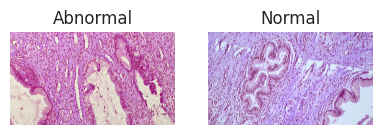

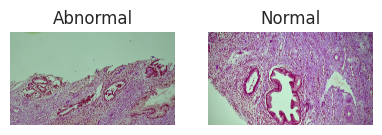

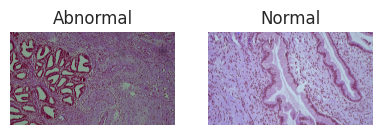

In [23]:
for i in range(3):
  load_random_img(base_ds,cervical_classes)

In [25]:
batch_size = 16
img_height, img_width = 299, 299
input_shape = (img_height, img_width, 3)

CONFIG = dict(
    batch_size=16,
    img_height=299,
    img_width=299,
)

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [27]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1651 images belonging to 2 classes.
Found 206 images belonging to 2 classes.
Found 207 images belonging to 2 classes.


In [28]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [29]:
model1 = tf.keras.applications.Xception(input_shape =input_shape,
                                            include_top = False,
                                            weights = 'imagenet')

model1.trainable =True
inputs = tf.keras.Input(input_shape)
x = model1(inputs)
model1_out = model1.layers[-1].output # last layer's output.
x = tf.keras.layers.GlobalAveragePooling2D()(model1_out)
x= tf.keras.layers.BatchNormalization()(x)
x= tf.keras.layers.Dense(512, activation="relu", 
                         kernel_regularizer = tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='softmax',name="model1_out")(x)
model1= tf.keras.Model(model1.input, x)



model2= tf.keras.applications.DenseNet201(input_shape =input_shape,
                                            include_top = False,
                                            weights = 'imagenet')

model2.trainable =True
inputs = tf.keras.Input(input_shape)
x = model2(inputs)
model2_out = model2.layers[-1].output # last layer's output.
x = tf.keras.layers.GlobalAveragePooling2D()(model2_out)
x= tf.keras.layers.BatchNormalization()(x)
x= tf.keras.layers.Dense(512, activation="relu", 
                         kernel_regularizer = tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='softmax',name="model2_out")(x)
model2= tf.keras.Model(model2.input, x)


models = [model1, model2]
model_input = tf.keras.Input(shape=(input_shape))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
model = tf.keras.Model(inputs = model_input, 
                                outputs = ensemble_output, 
                                name='ensemble')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2)         │ 21,919,786 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 2)         │ 19,314,242 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 2)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_3[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,234,028 (157.30 MB)

 Trainable params: 40,942,508 (156.18 MB)

 Non-trainable params: 291,520 (1.11 MB)

In [31]:
history_ensemble =model.fit(train_ds, epochs = 50, validation_data = val_ds)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-19 17:48:50.346543: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_158220__.109930] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-19 17:49:03.232235: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m12.885798438s

********************************
[Compiling module a_inference_one_step_on_data_158220__.109930] Very slow compile? If you want to file a bug, run with envvar XLA_

 70/104 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5727 - loss: 0.7345

2024-04-19 17:56:55.359893: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m36.617512703s

********************************
[Compiling module a_inference_one_step_on_data_158220__.109930] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
W0000 00:00:1713549415.607154     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713549415.676299     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6114 - loss: 0.6882

W0000 00:00:1713549485.633404     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713549485.653550     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 1109s 6s/step - accuracy: 0.6123 - loss: 0.6870 - val_accuracy: 0.7767 - val_loss: 0.5554
Epoch 2/50


W0000 00:00:1713549546.606919     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713549546.620547     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8640 - loss: 0.3769 - val_accuracy: 0.8592 - val_loss: 0.4085
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8946 - loss: 0.2848 - val_accuracy: 0.8883 - val_loss: 0.3044
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9277 - loss: 0.2272 - val_accuracy: 0.9126 - val_loss: 0.2113
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9095 - loss: 0.2280 - val_accuracy: 0.9223 - val_loss: 0.1957
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9390 - loss: 0.1733 - val_accuracy: 0.9417 - val_loss: 0.1645
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9406 - loss: 0.1734 - val_accuracy: 0.9563 - val_loss: 0.1681
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9490 - loss: 0.1593 - val_accuracy: 0.9272 - val_loss: 0.1745
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9515 - loss: 0.1391 - val_accuracy: 0.951

In [37]:
score_ensemble_new_val = model.evaluate(val_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_ensemble_new_val[0]}\nAccuracy: {score_ensemble_new_val[1]*100}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9807 - loss: 0.1199
Pretrained Network Fine-tuned 
Loss: 0.11165892332792282
Accuracy: 98.05825352668762


In [36]:
score_ensemble_new_train = model.evaluate(train_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_ensemble_new_train[0]}\nAccuracy: {score_ensemble_new_train[1]*100}')

104/104 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 1.0000 - loss: 0.0161
Pretrained Network Fine-tuned 
Loss: 0.01639314368367195
Accuracy: 100.0


W0000 00:00:1713557486.392512     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713557486.454733     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [38]:
score_ensemble_new_test = model.evaluate(test_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_ensemble_new_test[0]}\nAccuracy: {score_ensemble_new_test[1]*100}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 913ms/step - accuracy: 1.0000 - loss: 0.0553
Pretrained Network Fine-tuned 
Loss: 0.047802604734897614
Accuracy: 100.0


In [39]:
# Initialize lists to store metrics
epochs = list(range(1, len(history_ensemble.history['loss']) + 1)) 
train_loss = history_ensemble.history['loss']
val_loss = history_ensemble.history['val_loss']
train_accuracy = history_ensemble.history['accuracy']
val_accuracy = history_ensemble.history['val_accuracy']

# Create a DataFrame to store the metrics
df_ensemble = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_ensemble.to_excel('ensemble_training_metrics.xlsx', index=False)

In [40]:
Y_pred_ensemble =model.predict(test_ds)

 1/13 ━━━━━━━━━━━━━━━━━━━━ 4:17 21s/step

W0000 00:00:1713557738.587694     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713557738.606875     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step 


W0000 00:00:1713557769.195410     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713557769.215907     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


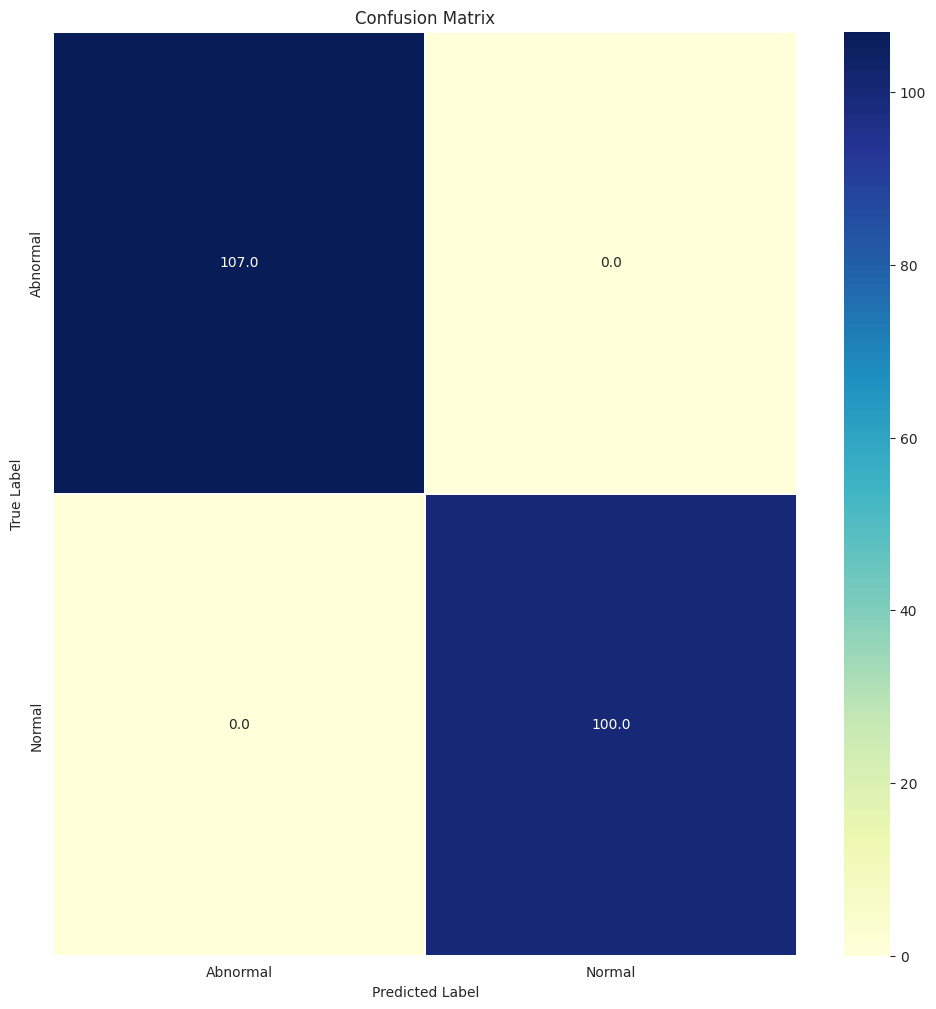

In [43]:
y_pred_ensemble = np.argmax(Y_pred_ensemble, axis=1)
confusion_mtx = confusion_matrix(y_pred_ensemble, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cervical_classes)
plt.title("Confusion Matrix")
plt.show()

In [44]:
report_ensemble = classification_report(test_ds.classes, y_pred_ensemble, target_names=cervical_classes, output_dict=True)
df_ensemble = pd.DataFrame(report_ensemble).transpose()
df_ensemble

,precision,recall,f1-score,support
Abnormal,1.0,1.0,1.0,107.0
Normal,1.0,1.0,1.0,100.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,207.0
weighted avg,1.0,1.0,1.0,207.0


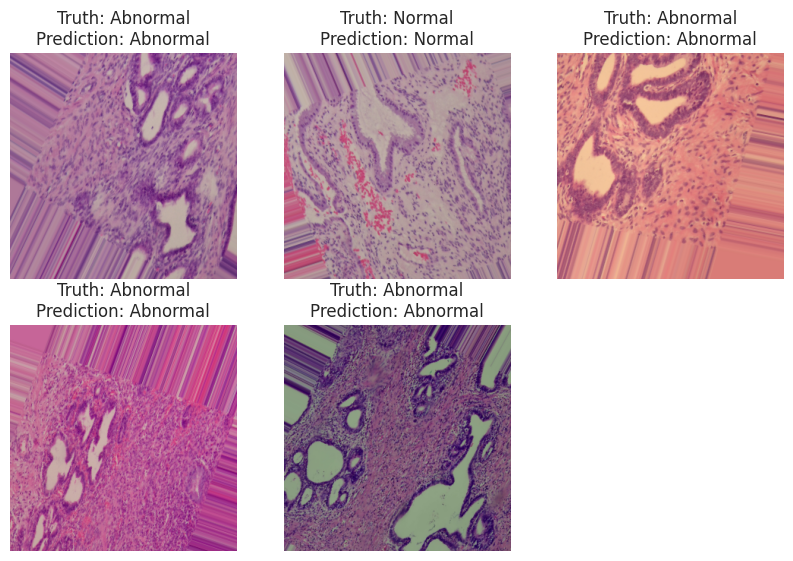

In [47]:
# Assuming train_ds is a directory iterator
x, label = next(train_ds)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i] == 1)[0][0]
    predict = model(x[i][tf.newaxis, ...])  # Assuming model is already defined
    score = tf.nn.softmax(predict[0])
    score_label = cervical_classes[np.argmax(score)]
    plt.title(f'Truth: {cervical_classes[result]}\nPrediction: {score_label}')
    plt.axis(False)
plt.show()


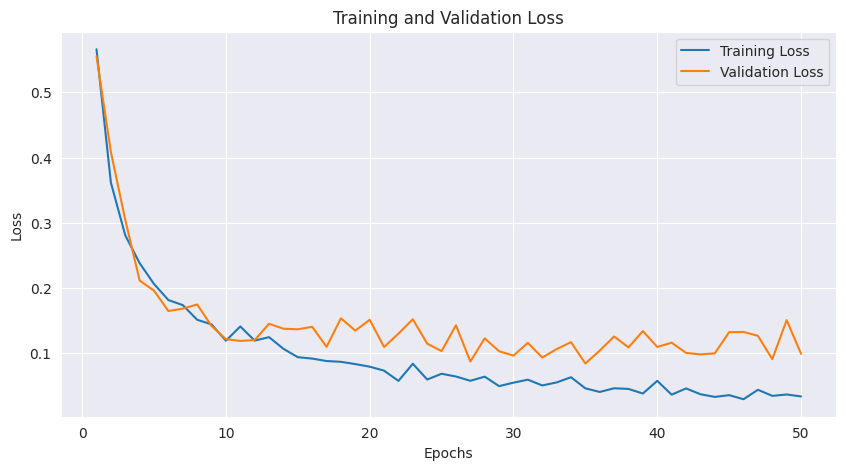

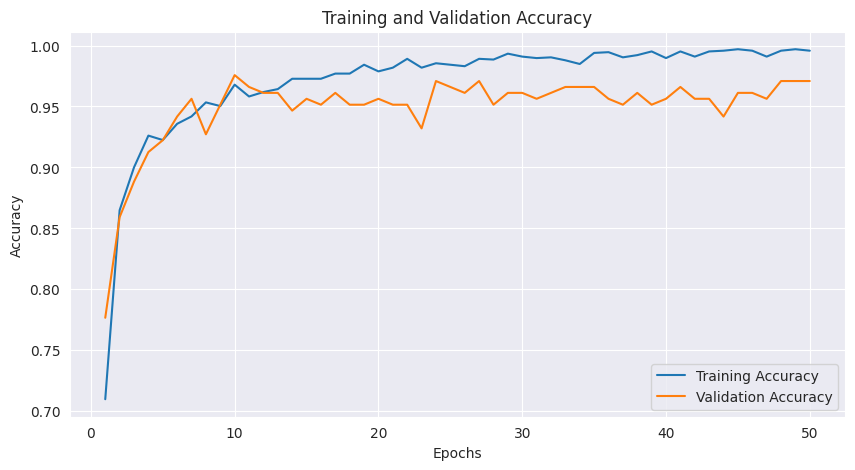

In [48]:
#Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
model_ensemble_json = model.to_json()
with open("model_ensemble.json", "w") as json_file:
    json_file.write(model_ensemble_json)
# serialize weights to HDF5
model.save("model_ensemble.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [65]:
import numpy as np
from sklearn.metrics import average_precision_score

# Assuming test_ds is a directory iterator
x, y_true = next(test_ds)

# Assuming model is already defined and makes predictions
y_pred = model.predict(x)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate mAP
mAP = average_precision_score(y_true, y_pred_binary)

# Calculate mAP@20
# Sort predictions and ground truth by predicted probability of positive class
sorted_indices = np.argsort(y_pred[:, 1])[::-1]
y_true_sorted = y_true[sorted_indices][:20]

# Calculate average precision at each position up to 20
#ap_at_k = np.cumsum(y_true_sorted) / np.arange(1, 21)
#mAP_20 = np.mean(ap_at_k)

print(f"Mean Average Precision (mAP): {mAP}")
#print(f"Mean Average Precision at 20 (mAP@20): {mAP_20}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mean Average Precision (mAP): 0.5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [67]:
import numpy as np
from sklearn.metrics import average_precision_score

# Assuming test_ds is a directory iterator
x, y_true = next(test_ds)

# Assuming model is already defined and makes predictions
y_pred = model.predict(x)
# Assuming threshold is 0.5
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

#print(y_true)
#print(y_pred_binary)

mAP = average_precision_score(y_true, y_pred_binary)
print(mAP)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0.5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


**DenseNet201**

In [51]:
densenet = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
densenet.trainable = True
inputs = tf.keras.Input(input_shape)
x = densenet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model_densenet = tf.keras.Model(inputs, outputs)

In [52]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='categorical_crossentropy', metrics=['accuracy'])
model_densenet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 9, 9, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,291,138 (77.40 MB)

 Trainable params: 20,062,082 (76.53 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [68]:
history_densenet = model_densenet.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
 93/104 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7270 - loss: 0.5665

2024-04-19 21:13:02.111548: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_427751__.89270] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-19 21:14:23.292569: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m21.18113864s

********************************
[Compiling module a_inference_one_step_on_data_427751__.89270] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7332 - loss: 0.5576

W0000 00:00:1713561289.438094     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.7338 - loss: 0.5568 - val_accuracy: 0.6893 - val_loss: 0.5885
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9066 - loss: 0.2756 - val_accuracy: 0.8204 - val_loss: 0.4084
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9235 - loss: 0.2011 - val_accuracy: 0.8981 - val_loss: 0.2338
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9421 - loss: 0.1570 - val_accuracy: 0.9515 - val_loss: 0.1314
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9395 - loss: 0.1417 - val_accuracy: 0.9563 - val_loss: 0.1151
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9648 - loss: 0.1027 - val_accuracy: 0.9466 - val_loss: 0.0952
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9722 - loss: 0.0805 - val_accuracy: 0.9612 - val_loss: 0.1186
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9734 - loss: 0.0907 - val_accuracy: 0.956

In [69]:
score_densenet_val = model_densenet.evaluate(val_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_densenet_val[0]}\nAccuracy: {score_densenet_val[1]*100}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9682 - loss: 0.0484
Pretrained Network Fine-tuned 
Loss: 0.09485204517841339
Accuracy: 96.11650705337524


In [71]:
score_densenet_test = model_densenet.evaluate(test_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_densenet_test[0]}\nAccuracy: {score_densenet_test[1]*100}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9863 - loss: 0.0400
Pretrained Network Fine-tuned 
Loss: 0.038134846836328506
Accuracy: 98.55072498321533


W0000 00:00:1713570975.789634     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [73]:
score_densenet_train = model_densenet.evaluate(train_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_densenet_train[0]}\nAccuracy: {score_densenet_train[1]*100}')

104/104 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 1.0000 - loss: 4.5597e-04
Pretrained Network Fine-tuned 
Loss: 0.0005320810014382005
Accuracy: 100.0


In [74]:
# Initialize lists to store metrics
epochs = list(range(1, len(history_densenet.history['loss']) + 1)) 
train_loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
train_accuracy = history_densenet.history['accuracy']
val_accuracy = history_densenet.history['val_accuracy']

# Create a DataFrame to store the metrics
df_densenet = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_densenet.to_excel('densenet_training_metrics.xlsx', index=False)

In [82]:
Y_pred_densenet =model_densenet.predict(test_ds)

 2/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step 

W0000 00:00:1713571594.675599     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step 


W0000 00:00:1713571622.575365     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


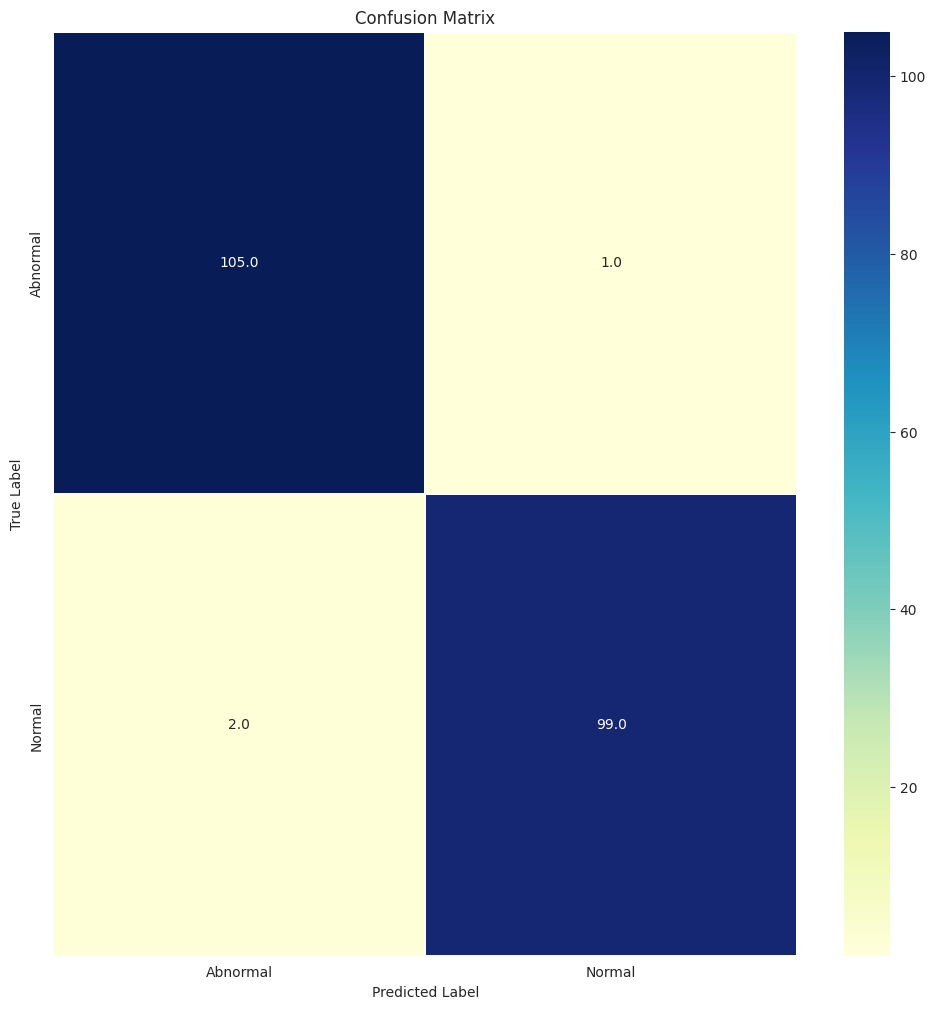

In [83]:
y_pred_densenet = np.argmax(Y_pred_densenet, axis=1)
confusion_mtx = confusion_matrix(y_pred_densenet, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cervical_classes)
plt.title("Confusion Matrix")
plt.show()

In [84]:
report_densenet = classification_report(test_ds.classes, y_pred_densenet, target_names=cervical_classes, output_dict=True)
df_densenet = pd.DataFrame(report_densenet).transpose()
df_densenet

,precision,recall,f1-score,support
Abnormal,0.990566,0.981308,0.985915,107.000000
Normal,0.980198,0.990000,0.985075,100.000000
accuracy,0.985507,0.985507,0.985507,0.985507
macro avg,0.985382,0.985654,0.985495,207.000000
weighted avg,0.985557,0.985507,0.985509,207.000000


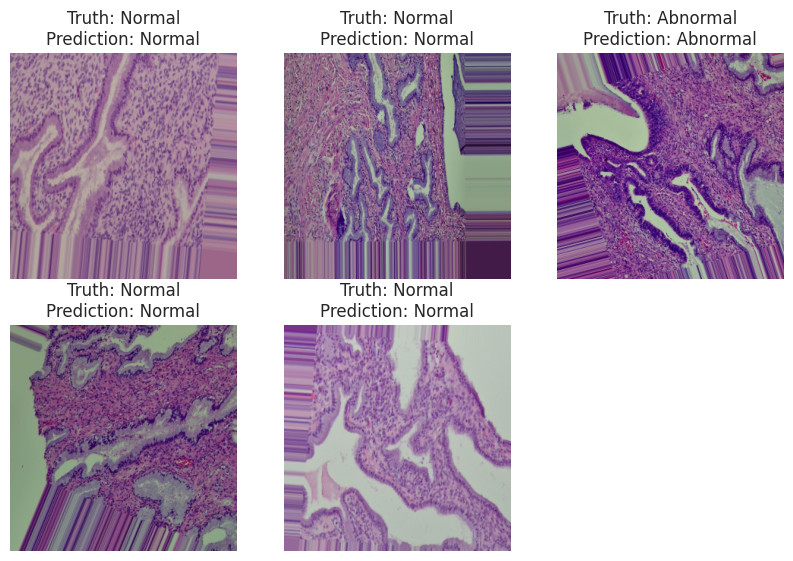

In [85]:
# Assuming train_ds is a directory iterator
x, label = next(train_ds)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i] == 1)[0][0]
    predict = model_densenet(x[i][tf.newaxis, ...])  # Assuming model is already defined
    score = tf.nn.softmax(predict[0])
    score_label = cervical_classes[np.argmax(score)]
    plt.title(f'Truth: {cervical_classes[result]}\nPrediction: {score_label}')
    plt.axis(False)
plt.show()


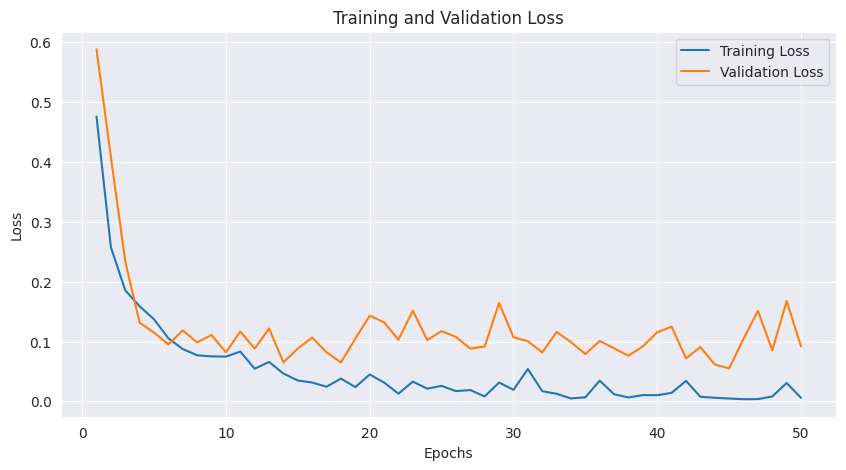

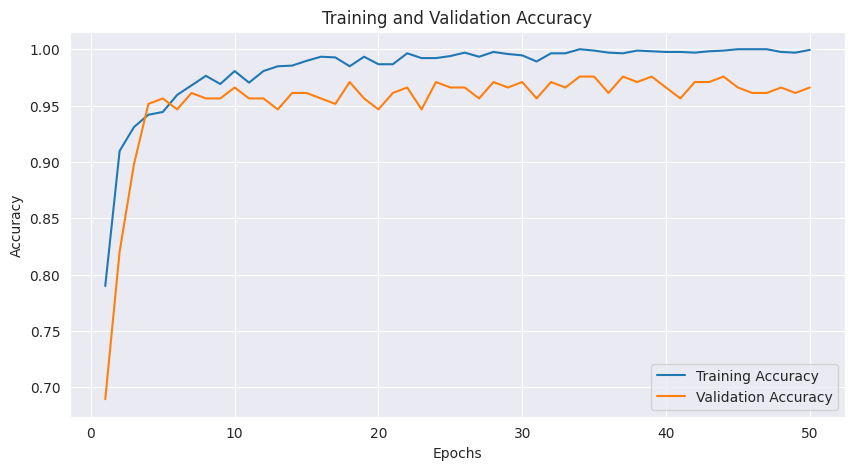

In [86]:
#Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
model_densenet_json = model_densenet.to_json()
with open("model_densenet.json", "w") as json_file:
    json_file.write(model_densenet_json)
# serialize weights to HDF5
model_densenet.save("model_densenet.h5")

ValueError: Unable to synchronously create dataset (name already exists)

**Xception**

In [90]:
xception = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=input_shape)
xception.trainable = True
inputs = tf.keras.Input(input_shape)
x = xception(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model_xception = tf.keras.Model(inputs, outputs)

In [91]:
model_xception.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='categorical_crossentropy', metrics=['accuracy'])
model_xception.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,961,706 (87.59 MB)

 Trainable params: 22,907,178 (87.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [93]:
history_xception = model_xception.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6444 - loss: 0.6480

W0000 00:00:1713572305.113847     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6451 - loss: 0.6475 - val_accuracy: 0.8301 - val_loss: 0.5197
Epoch 2/50


W0000 00:00:1713572324.555044     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8317 - loss: 0.4474 - val_accuracy: 0.9078 - val_loss: 0.2978
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8950 - loss: 0.2793 - val_accuracy: 0.9272 - val_loss: 0.2100
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9167 - loss: 0.2235 - val_accuracy: 0.9369 - val_loss: 0.1929
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9284 - loss: 0.1981 - val_accuracy: 0.9417 - val_loss: 0.1583
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9458 - loss: 0.1527 - val_accuracy: 0.9515 - val_loss: 0.1274
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9521 - loss: 0.1383 - val_accuracy: 0.9466 - val_loss: 0.1296
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9492 - loss: 0.1211 - val_accuracy: 0.9466 - val_loss: 0.1431
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9710 - loss: 0.0861 - val_accuracy: 0.941

In [1]:
score_xception_val = model_xception.evaluate(val_ds, verbose=1)
print(f'Pretrained Network Fine-tuned \nLoss: {score_xception_val[0]}\nAccuracy: {score_xception_val[1]*100}')

NameError: name 'model_xception' is not defined